# Use Inscopix python API to analyze multiple calcium recordings in time series

## Step 0. install jupyter notebook nbextensions to view table of contents


To best view and navigate this template, installing [jupyter notebook nbextensions](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/toc2/README.html) to show table of contents (TOC) sidebar is highly recommended.

1. After activating isxenv (conda activate isxenv), paste the following two lines into the command line one at a time (more instructions see [this link](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html)).

```
pip install https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tarball/master

jupyter contrib nbextension install --user
```

2. After the installation completes and "jupyter notebook" program is initiated (by typing "jupyter notebook" inside isxenv), a new nbextensions tab will appear to the right of the Files tab. Users can enable TOC within the nbextensions tab and toggle the TOC button on and off from the tool bar.


3. ExecuteTime is also recommended to be turned on in the nbextensions tab to view the execution time for each cell (or use %%time function instead in selective cells)


## Step 1. prepare files for analysis

### 1.1 import libraries

In [1]:
import isx  # Inscopix API
import os  # operating system
import json  # to save and load json files
from pathlib import Path  # to work with dir
import shutil  # to move files
import textwrap  # to format multiline string text
from itertools import islice  # list manipulation
from functools import partial  # reset function default argument
import numpy as np  # to manipulate data matrix
import numpy.matlib  # to manipulate data matrix
from scipy import stats  # calculate zscore
import pandas as pd  # data analysis library
import matplotlib.pyplot as plt  # data visualization
import matplotlib.lines as mlines  # figure legend styling

# to suppress warnings from the output window
import warnings
warnings.filterwarnings("ignore")

# to render the figures inside the current notebook
%matplotlib inline

### 1.2 set folder path and organize recordings

### Users can download the longitudinal dataset from [Inscopix website](https://support.inscopix.com/support/products/data-processing-software/inscopix-data-processing-v131)

### **USER INPUT REQUIRED (1 of 6)**

In [2]:
###############################################################################
#--------USERS SPECIFY AN INPUT FOLDER WHERE THEY STORE THE RECORDINGS--------#
###############################################################################

"""
1. modify the path to match user's own dir
2. in windows system, a copy/pasted path needs to be prefixed with r
    or use \\ structure such as 'C:\\Path\\to\\parent\\folder'
3. Path library is used to standardize path format
    and be cross-platform compatible
"""

# set current working folder; change 'D:' to match your own folder
Parent_folder_User_defined = Path(r'D:\demo')

# for the Inscopix demo dataset the raw recordings are stored in a subfolder
# and so we append the folder path, which may not be necessary and so
# should be modified to match users' own folder structure

data_dir = \
    Parent_folder_User_defined /  \
    "S1prism_AAV1_demo_with_LR" /  \
    "S1prism_AAV1_demo_v2_data"

In [3]:
# for the demo dataset, we store the processed files
# in a child folder "processed"

output_dir = data_dir / "processed"
# create the output folder if it does not exist
output_dir.mkdir(exist_ok=True)

print('The input recording folder:', data_dir.name)
print('The output folder:', output_dir.name)

The input recording folder: S1prism_AAV1_demo_v2_data
The output folder: processed


### **USER INPUT REQUIRED (2 of 6)**

In [4]:
###############################################################################
#-------FOLLOW THE DEMO DATASET STRUCTURE TO ORGANIZE RECORDINGS--------------#
#--SO LABEL OF EACH SERIES IS FOLLOWED BY A RECORDING LIST FROM THAT SERIES---#
###############################################################################

# each day contains a time series of four sessions in this example

series_rec_names = {
    'day_1':
    [
        'recording_20160613_105808',
        'recording_20160613_110507',
        'recording_20160613_111207',
        'recording_20160613_111907',
    ],
    'day_4':
    [
        'recording_20160616_102500',
        'recording_20160616_103200',
        'recording_20160616_103900',
        'recording_20160616_104600',
    ]}

In [5]:
# store the series label, list of recordings and
# the No. of recordings in each series

day_labels = list(series_rec_names.keys())
recordings_series = list(series_rec_names.values())
num_rec_per_series = [len(child_list) for child_list in recordings_series]

# print series label and the recording No. for each series
print('Label of time series:', day_labels)
print('Number of recordings for each day:', num_rec_per_series)

# print the recording list from one example series
print('{} recording list:'.format(
    day_labels[0]), recordings_series[0], '\n')

Label of time series: ['day_1', 'day_4']
Number of recordings for each day: [4, 4]
day_1 recording list: ['recording_20160613_105808', 'recording_20160613_110507', 'recording_20160613_111207', 'recording_20160613_111907'] 



### 1.3 define functions to merge time series or split a single list to time series

In [6]:
def split2series(Input, length_to_split=num_rec_per_series):
    """
    Convert a straight list into a nested one, a list of time series.
    for example: [1, 2, 3, 4] --> [[1, 2], [3, 4]]
    given an input length [2, 2]

    Args:
        Input: straight list such as [1, 2, 3, 4]
        length_to_split: No. of elements to be distributed into nested lists
    Return:
        Output: Nested list such as [[1, 2], [3, 4]]
    """

    # Using islice to redistribute the elements from the input list
    Inputt = iter(Input)
    Output = [list(islice(Inputt, elem))
              for elem in length_to_split]
    return Output


def merge_series(Input):
    """
    Flatten a nested list, a list of time series into a single list
    for example: [[1, 2], [3, 4]] --> [1, 2, 3, 4]

    Args:
        Input: Nested list
    Return:
        Output: flattened list
    """

    if any(isinstance(i, list) for i in Input):
        Output = [recording for child_list in Input for recording in child_list]
    else:
        Output = Input  # skip the conversion if input list is not nested
    return Output


def series_suffix(suffix, dir_series, output_dir=output_dir):

    """
    add suffix to series filename
    1. The input dir series are merged first
    2. The merged list is used to add suffix to filenames
    3. The new filenames list is split to new dir series
       if input list is nested

    Args:
        dir_series: input dir series
                    Default: raw recording dirs
        suffix: User input for filename suffixing
        output_dir: the output folder to store new files
                    Default: output dir specified from the previous step
    Return:
        Output: new dir series with suffixed filenames
    """

    old_names = merge_series(dir_series)  # step 1
    new_names = [str(Path(output_dir, Path(dir).stem \
        + suffix)) for dir in old_names]  # step 2
    if any(isinstance(i, list) for i in dir_series):
        num_rec = [len(child_list) for child_list in dir_series]
        Output = split2series(new_names, length_to_split=num_rec)
    else:
        Output = new_names  # step 3 skipped

    return Output

def series_label_prefix(suffix, prefix=day_labels, output_dir=output_dir):
    """
    join series label prefix with suffix input

    Args:
        suffix: input, filename suffix to be joined
        prefix: series labels as prefix
        output_dir: the output folder to store dirs with new names
                    Default: output dir specified from the previous step
    Return:
        Output: new dir list with prefixed filenames
    """
    return [str(Path(output_dir, name + suffix)) for name in prefix]


# get full dir of the raw recordings
# may need to remove -PP-PP if processing users' own recordings
rec_dir_series = series_suffix(
                '-PP-PP.isxd', recordings_series, output_dir=data_dir)

### 1.4 get full dir for the input recordings

### **USER INPUT REQUIRED (3 of 6)**

In [7]:
###############################################################################
#----------FOR THE DEMO DATASET THE RECORDINGS HAVE BEEN PREPROCESSED---------#
#----------THEREFORE THE NAMES WERE SUFFIXED WITH -PP-PP----------------------#
#--------- USERS MAY NEED TO REMOVE -PP-PP TO MATCH THEIR OWN RECORDINGS------#
###############################################################################

# reset series_suffix function default argument
# add suffix to raw recording names

series_suffix = partial(series_suffix, dir_series=rec_dir_series)
print('The total No. of time series:', len(rec_dir_series))
# print(Path(rec_dir_series[0][0]).name)

The total No. of time series: 2


In [8]:
# update series_rec_names recording list with full dirs

for day_i, key in enumerate(series_rec_names):
    series_rec_names[key] = rec_dir_series[day_i]

# save as json
with open( output_dir / 'series_rec_names.json', 'w') as f:
    json.dump(series_rec_names, f)

### 1.5 make output file names

In [9]:
"""
make filenames for output files

abbreviation for filename suffix:

pp: preprocess
bp: bandpass filter
mc: motion correction
cnmfe-cellset: cnmfe cellset
cnmfe_event: cnmfe event set
dff: deltaF/F0
pca_ica: pca/ica cellset
pca_ica_event: pca/ica event set

"""

# make new isxd filenames for processed files

pp_files_series = series_suffix('-PP.isxd')
bp_files_series = series_suffix('-PP-BP.isxd')
mc_files_series = series_suffix('-PP-BP-MC.isxd')
cnmfe_files_series = series_suffix('-PP-BP-MC-cnmfe-cellset.isxd')
cnmfe_eventfiles_series = series_suffix('-PP-BP-MC-cnmfe_event.isxd')
dff_files_series = series_suffix('-PP-BP-MC-dff.isxd')
pcaica_files_series = series_suffix('-PP-BP-MC-dff-pca_ica.isxd')
pcaica_eventfiles_series = series_suffix('-PP-BP-MC-dff-pca_ica_event.isxd')

# make csv filenames to store frame by frame x y shift during motion correction
translation_files = series_suffix(
                    '-translations.csv', dir_series=mc_files_series)

In [10]:
"""
Make filenames for other output files:

mean_proj_files: mean projection file from motion correction
crop_rect_files: store movie coordinates after motion correction
                i.e. top left width height values
maxdff_files: maximal projection file from df/f0 movies
cnmfe_csv: cell traces csv files from cnmfe cellset
cnmfe_tiff: cell map tiff files, one per cell from cnmfe cellset
pcaica_csv: cell traces csv files from pca-ica cellset
pcaica_tiff: cell map tiff files, one per cell from pca-ica cellset
pcaica_event_csv: cell events csv files from pca-ica event set
pcaica_event_props_csv: cell event metrics csv files from pca-ica event set

"""

mean_proj_files = series_label_prefix('-mean_image.isxd')
crop_rect_files = series_label_prefix('-crop_rect.csv')
maxdff_files = series_label_prefix('-maxdff.isxd')

cnmfe_csv = series_label_prefix('-cnmfe-cellset.csv')
cnmfe_tiff = series_label_prefix('-cnmfe-cellset.tiff')
pcaica_csv = series_label_prefix('-pca-ica-cellset.csv')
pcaica_tiff = series_label_prefix('-pca-ica-cellset.tiff')
pcaica_event_csv = series_label_prefix('-pca-ica-cellset-events.csv')
pcaica_event_props_csv = series_label_prefix('-pca-ica-cellset-events-props.csv')

## Step 2. preprocess time series recordings
- ### temporal and spatial downsampling

### **USER INPUT REQUIRED (4 of 6)**

In [11]:
###############################################################################
#---PLEASE USE A PROPER TEMPORAL DOWNSAMPLING FACTOR TO MATCH THE GCAMP TYPE--#
#----4X SPATIAL DOWNSAMPLING IS RECOMMENDED FOR LONG RECORDINGS OR CNMFE------#
#-----FOR PARAMETER TUNING, CROPPING OR TRIM MOVIE COULD SAVE TIME------------#
###############################################################################

# Adjust the two parameter below to match your own datasets.
# The factors used below are for demo purpose to save time of processing
# by reducing file size both temporally and spatially.

tp_downsampling = 1
sp_downsampling = 2

# use for loop to preprocess time series one at a time
# day_i: 0,1... matching day index (0, 1 in this example)

print('Preprocessing, please wait...\n')

for day_i, day_label in enumerate(day_labels):

    # Preprocess the recordings by spatially downsampling by a factor of 2
    # and temporally downsampling by a factor of 1 (no downsampling).
    # In the example data set, some downsampling has already been performed
    # but we do it again for demonstration purposes
    # and to speed everything up here.

    if not os.path.exists(pp_files_series[day_i][0]):
        # skip the series if its first recording exists
        isx.preprocess(
            input_movie_files=rec_dir_series[day_i],  # one series per loop
            output_movie_files=pp_files_series[day_i],  # one series per loop
            temporal_downsample_factor=tp_downsampling,
            spatial_downsample_factor=sp_downsampling,
            crop_rect=None,
            fix_defective_pixels=True,
            trim_early_frames=True)
        print('{} preprocessing completed'.format(day_label))
    else:
        print(Path(pp_files_series[day_i][0]).name
              + " already exists, series skipped")

Preprocessing, please wait...

day_1 preprocessing completed
day_4 preprocessing completed


## Step 3. apply bandpass filter

In [12]:
# use for loop to apply bandpass filter to time series one at a time
# Perform spatial bandpass filtering with default values.

print('Applying bandpass filter, please wait...\n')

for day_i, day_label in enumerate(day_labels):

    if not os.path.exists(bp_files_series[day_i][0]):
        isx.spatial_filter(
            input_movie_files=pp_files_series[day_i],
            output_movie_files=bp_files_series[day_i],
            low_cutoff=0.005,
            high_cutoff=0.5,
            retain_mean=False,
            # leave subtract_global_minimum setting as true
            # for correct dff display
            subtract_global_minimum=True)
        print('{} bandpass filtering completed'.format(day_label))
    else:
        print(Path(bp_files_series[day_i][0]).name
              + " already exists, series skipped")

Applying bandpass filter, please wait...

day_1 bandpass filtering completed
day_4 bandpass filtering completed


## Step 4. apply motion correction

### Step 4.1 get mean frame from temporal projection

In [13]:
# use the mean frame as a reference to apply motion correction.

for day_i, (day_label, mean_proj_file) \
        in enumerate(zip(day_labels, mean_proj_files)):

    if not os.path.exists(mean_proj_file):

        isx.project_movie(
            input_movie_files=bp_files_series[day_i],
            output_image_file=mean_proj_file,
            stat_type='mean')  # types: 'mean', 'min', or 'max'
        message = """
            {} temporal projection completed.
            A new file has been generated and will be used
            as a reference frame for motion correction
            """.format(day_label)
        print(textwrap.dedent(message))

    else:
        print(Path(mean_proj_file).name
              + " already exists, projection process skipped")


day_1 temporal projection completed.
A new file has been generated and will be used
as a reference frame for motion correction


day_4 temporal projection completed.
A new file has been generated and will be used
as a reference frame for motion correction



### Step 4.2 apply motion correction

In [14]:
# use for loop to apply motion correction one series at a time

print('Applying motion correction. Please wait...\n')

for day_i, (day_label, mean_proj_file) \
        in enumerate(zip(day_labels, mean_proj_files)):

    # apply motion correction
    if not os.path.exists(mc_files_series[day_i][0]):
        isx.motion_correct(
            input_movie_files=bp_files_series[day_i],
            output_movie_files=mc_files_series[day_i],
            max_translation=20,
            low_bandpass_cutoff=None,
            high_bandpass_cutoff=None,
            roi=None,
            # use movie and frame index to set a fixed frame as reference
            # turned off if set to 0
            reference_segment_index=0,
            reference_frame_index=0,
            # use the mean projection file generated in the previous step
            # as a reference frame for motion correction
            reference_file_name=mean_proj_file,
            global_registration_weight=1.0,
            output_translation_files=translation_files[day_i],
            output_crop_rect_file=crop_rect_files[day_i])
        print('{} motion correction completed'.format(day_label))
    else:
        print(Path(mc_files_series[day_i][0]).name
              + " already exists, series skipped")

Applying motion correction. Please wait...

day_1 motion correction completed
day_4 motion correction completed


## **Step 5: Cell Detection Method 1: CNMFe**

### Step 5.1 apply CNMFe algorithm to detect cells

### **USER INPUT REQUIRED (5 of 6)**

In [15]:
%%time

###############################################################################
#---THE CNMFE ALGORITHM APPLIES TO THE CONCATENATED MOVIE FROM THE SERIES-----#
#--------EVERY RECORDING IN THIS SERIES WILL HAVE THE SAME CELLMAPS-----------#
#---------EVEN THOUGHT THE OUTPUT IS A CNMFE CELLSET SERIES-------------------#
###############################################################################
#----------PLEASE REFER TO IDPS MANUAL FOR PARAMETER SETTING TIPS-------------#
#----------ADJUST CELL_DIAMETER, MIN_PNR AND MIN_CORR VALUES AS NEEDED--------#
###############################################################################

print('Applying CNMFe algorithm to detect cells, please wait...\n')

# make cnmfe subfolder to store temporal files including concatenated TIFFs
export_path = output_dir / "cnmfe_tmp"
export_path.mkdir(exist_ok=True)

# use motion corrected movie series as input and do not use df/f0 movie
# since the background info will be used for noise estimation

for day_i, day_label in enumerate(day_labels):

    if not os.path.exists(cnmfe_files_series[day_i][0]):
        isx.run_cnmfe(
            input_movie_files=mc_files_series[day_i],
            output_cell_set_files=cnmfe_files_series[day_i],
            output_dir=str(export_path),
            cell_diameter=15,
            min_corr=0.8,
            min_pnr=20,
            bg_spatial_subsampling=2,
            ring_size_factor=1.4,
            gaussian_kernel_size=0,
            closing_kernel_size=0,
            merge_threshold=0.7,
            processing_mode='parallel_patches',
            num_threads=4,
            patch_size=80,
            patch_overlap=20,
            output_unit_type='df_over_noise')
        message = """
            {} CNMFe cell detection completed. A few temporary files
            have been generated in the cnmfe_tmp subfolder\n""".format(day_label)
        print(textwrap.dedent(message))
    else:
        print(Path(cnmfe_files_series[day_i][0]).name
              + " already exists, series skipped")

Applying CNMFe algorithm to detect cells, please wait...


day_1 CNMFe cell detection completed. A few temporary files
have been generated in the cnmfe_tmp subfolder


day_4 CNMFe cell detection completed. A few temporary files
have been generated in the cnmfe_tmp subfolder

Wall time: 22min 11s


### Step 5.2 define a function to move files

In [16]:
def move_files(source, destination, type='.tiff'):
    """
    move files from source to destination, filtered by file type

    Parameters:
        source: path for source folder
        destination: path for destination folder
        type: file extension, by default only move tiff files

    Returns:
        None

    """
    if not os.path.exists(destination):
        os.mkdir(destination)  # make new subfolder
        # get file list from the source folder
        filelist = os.listdir(source)
        for file in filelist:
            if file.endswith(type):  # filter by file type
                shutil.move(source / file, destination / file)
    else:
        print("Tiff folder already exists, no files were moved\n")

### Step 5.3 export cnmfe cell set traces and cellmaps

In [17]:
# export csv file for all cell traces
# export multiple cell maps, one tiff image for each cell

for day_i, day_label in enumerate(day_labels):
    if not os.path.exists(cnmfe_csv[day_i]):
        isx.export_cell_set_to_csv_tiff(
            input_cell_set_files=cnmfe_files_series[day_i],
            output_csv_file=cnmfe_csv[day_i],
            output_tiff_file=cnmfe_tiff[day_i],
            time_ref='start',
            output_props_file='')
        print("Export completed. Tiff files were stored in the tiff subfolder")
    else:
        print(Path(cnmfe_csv[day_i]).name
              + " already exists, exporting process skipped")

# move tiff files to subfolder
move_files(output_dir, output_dir / "cnmfe_tiff")

Export completed. Tiff files were stored in the tiff subfolder
Export completed. Tiff files were stored in the tiff subfolder


### Step 5.4 detect events using s.d threshold and decay time

In [18]:
# Run event detection on the CNMFe cell sets.

for day_i, day_label in enumerate(day_labels):

    if not os.path.exists(cnmfe_eventfiles_series[day_i][0]):
        isx.event_detection(
            input_cell_set_files=cnmfe_files_series[day_i],
            output_event_set_files=cnmfe_eventfiles_series[day_i],
            threshold=5,  # sigma threshold
            tau=0.2,  # default is 200ms for Gcamp6f
            event_time_ref='beginning',  # export other timing separately
            ignore_negative_transients=True,
            accepted_cells_only=False)
        print('Event detection completed for {}'.format(day_label))
    else:
        print(Path(cnmfe_eventfiles_series[day_i][0]).name
              + " already exists, process skipped")

Event detection completed for day_1
Event detection completed for day_4


### Step 5.5 automatically classify cell statuses as accepted or rejected

In [19]:
print('Applying auto classification. '+
      'Please wait...\n')

# make name for event filter
events_filters = [('SNR', '>', 3), ('Event Rate', '>', 0), ('Cell Size', '>', 0)]

for day_i, day_label in enumerate(day_labels):
    isx.auto_accept_reject(input_cell_set_files=cnmfe_files_series[day_i],
                           input_event_set_files=cnmfe_eventfiles_series[day_i],
                           filters=events_filters)
print('Auto classification completed. The cnmfe cellset has been updated.')

Applying auto classification. Please wait...

Auto classification completed. The cnmfe cellset has been updated.


## **Alt Step 5: Cell Detection Method 2: PCA/ICA**

### Alt Step 5.1 calculate deltaF/F0 from motion corrected movies

In [20]:
# use for loop to calculate deltaF/F0
print('Calculating deltaf/f0, please wait...\n')

for day_i, day_label in enumerate(day_labels):
    if not os.path.exists(dff_files_series[day_i][0]):
        isx.dff(input_movie_files=mc_files_series[day_i],
                output_movie_files=dff_files_series[day_i],
                f0_type='mean')
        print('A new df/f movie has been generated for',
              day_label)
    else:
        print(Path(dff_files_series[day_i][0]).name +
              " already exists, process skipped")

Calculating deltaf/f0, please wait...

A new df/f movie has been generated for day_1
A new df/f movie has been generated for day_4


### Alt Step 5.2 apply maximal projection for each time series

In [21]:
print('Projecting movies, please wait...\n')

# use for loop to project movies
for day_i, day_label in enumerate(day_labels):
    if not os.path.exists(maxdff_files[day_i]):  # skip if file exists
        isx.project_movie(
            input_movie_files=dff_files_series[day_i],
            output_image_file=maxdff_files[day_i],
            stat_type='max')  # types: 'mean', 'min', or 'max'
        print('Maximal projection from {} dff time series completed'
              .format(day_label))
    else:
        print(Path(maxdff_files[day_i]).name
              + " already exists, process skipped")

Projecting movies, please wait...

Maximal projection from day_1 dff time series completed
Maximal projection from day_4 dff time series completed


### Alt Step 5.3 display the maximal projection image

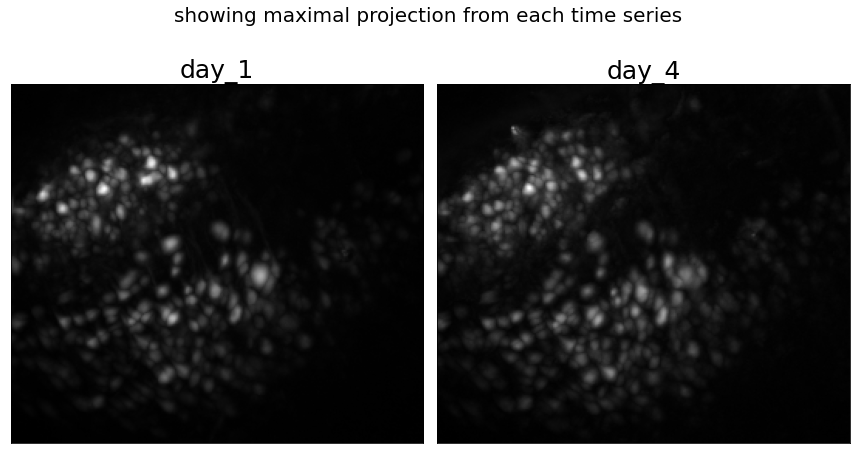

In [22]:
# set subplots, total # = rows * cols
cols = min(2, len(day_labels))
rows = int(len(day_labels)/cols)
axes = []
fig = plt.figure(figsize=(12, 7))
fig.suptitle('showing maximal projection from each time series', fontsize=20)

# display max projection of dff movie

for day_i in range(len(day_labels)):
    maxdff = isx.Image.read(maxdff_files[day_i]).get_data()
    axes.append(fig.add_subplot(rows, cols, day_i+1))
    subplot_title = (day_labels[day_i])
    axes[-1].set_title(subplot_title, fontsize=25)
    plt.imshow(maxdff, 'gray')
    plt.xticks([])
    plt.yticks([])
fig.tight_layout()
plt.show()

### **USER INPUT REQUIRED (6 of 6)**

### Alt Step 5.4 apply PCA/ICA algorithm to detect cells

In [23]:
%%time

###############################################################################
#--ADJUST NUM_ICS_EST TO MATCH WHAT IS SEEN FROM THE MAXIMAL PROJECTION IMAGE-#
#--IDPS 1.6 PROVIDES ISX.ESTIMATE_NUM_ICS TO HELP ESTIMATE THE NO. OF CELLS---#
#---INCREASE THE BLOCK_SIZE TO SPEED UP PROCESS IF SYSTEM HAS LOTS OF MEMORY--#
###############################################################################

# Run PCA-ICA on the DF/F movies.
# IDPS 1.6 supports auto estimation of the number of IC
# based on average cell size in pixels.

# The number of IC can also be specified manually
# to match the cell number shown from the dff maximal projection frame

print("""Applying PCA-ICA algorithm to segment cells.
This could take many minutes.
Please wait...\n""")

# apply PCA-ICA
for day_i, day_label in enumerate(day_labels):

    if not os.path.exists(pcaica_files_series[day_i][0]):

        # auto estimation of number of ICs

        num_ics_est = isx.estimate_num_ics(
                          maxdff_files[day_i],
                          average_diameter=10,
                          min_diameter=None,
                          max_diameter=None,
                          min_inter_dist=0)

        # uncomment the line below if manual estimation is preferred.
        # num_ics_est = 200

        print('The number of estimated ICs for {} is: '.format(day_label) + str(num_ics_est))

        isx.pca_ica(
            input_movie_files=dff_files_series[day_i],
            output_cell_set_files=pcaica_files_series[day_i],
            num_pcs=int(num_ics_est*0.9),
            num_ics=num_ics_est,
            unmix_type='spatial',
            ica_temporal_weight=0,
            max_iterations=100,
            convergence_threshold=1e-05,
            block_size=3000)  # use 1000 for slow computers
        print("PCA-ICA analysis completed."
              + "A new series of files has been generated for {}.\
            ".format(day_label))
    else:
        print(Path(pcaica_files_series[day_i][0]).name
              + " already exists, process skipped")

Applying PCA-ICA algorithm to segment cells.
This could take many minutes.
Please wait...

The number of estimated ICs for day_1 is: 192
PCA-ICA analysis completed.A new series of files has been generated for day_1.            
The number of estimated ICs for day_4 is: 214
PCA-ICA analysis completed.A new series of files has been generated for day_4.            
Wall time: 6min 33s


### Alt Step 5.5 detect events

In [24]:
# Run event detection on the PCA-ICA cell sets.

for day_i, day_label in enumerate(day_labels):

    if not os.path.exists(pcaica_eventfiles_series[day_i][0]):
        isx.event_detection(
            input_cell_set_files=pcaica_files_series[day_i],
            output_event_set_files=pcaica_eventfiles_series[day_i],
            threshold=5,  # sigma threshold
            tau=0.2,  # default is 200ms for Gcamp6f
            event_time_ref='beginning',  # export other timing separately
            ignore_negative_transients=True,
            accepted_cells_only=False)
        print('Event detection completed for {}'.format(day_label))
    else:
        print(Path(pcaica_eventfiles_series[day_i][0]).name
              + " already exists, process skipped")

Event detection completed for day_1
Event detection completed for day_4



### Alt Step 5.6 export events

In [25]:
for day_i, day_label in enumerate(day_labels):

    if not os.path.exists(pcaica_event_csv[day_i]):
        isx.export_event_set_to_csv(
            input_event_set_files=pcaica_eventfiles_series[day_i],
            output_csv_file=pcaica_event_csv[day_i],
            time_ref='start',
            output_props_file=pcaica_event_props_csv[day_i])
        print('Exporting calcium events completed.'.format(day_label))
    else:
        print(Path(pcaica_event_csv[day_i]).name
              + " already exists, process skipped")

Exporting calcium events completed.
Exporting calcium events completed.



### Alt Step 5.7 auto classify cells into accepted/rejected groups

In [26]:
print('Applying auto accept/reject filter based on SNR, event rate \
and single component number\n')

events_filters = [('SNR', '>', 3), ('Event Rate', '>', 0), ('# Comps', '=', 1)]

for day_i, day_label in enumerate(day_labels):

    isx.auto_accept_reject(
        input_cell_set_files=pcaica_files_series[day_i],
        input_event_set_files=pcaica_eventfiles_series[day_i],
        filters=events_filters)

    print("Auto classification completed for {}. ".format(day_label)
          + "The pca-ica cellset has been updated.")

Applying auto accept/reject filter based on SNR, event rate and single component number

Auto classification completed for day_1. The pca-ica cellset has been updated.
Auto classification completed for day_4. The pca-ica cellset has been updated.



### Alt Step 5.8 export PCA/ICA cellset traces and cellmaps

In [27]:
for day_i, _ in enumerate(cnmfe_eventfiles_series):

    if not os.path.exists(pcaica_csv[day_i]):
        isx.export_cell_set_to_csv_tiff(
            input_cell_set_files=pcaica_files_series[day_i],
            output_csv_file=pcaica_csv[day_i],
            output_tiff_file=pcaica_tiff[day_i],
            time_ref='start',
            output_props_file='')
        print("Export completed. Tiff files were stored in the tiff subfolder")
    else:
        print(Path(pcaica_csv[day_i]).name
              + " already exists, process skipped")

move_files(output_dir, output_dir / "pcaica_tiff")

Export completed. Tiff files were stored in the tiff subfolder
Export completed. Tiff files were stored in the tiff subfolder
